# Dataset Preparation for training your own object detection model from video recordings 

This notebook walks you through the steps to prepare a dataset for training your own object detection model in Amazon SageMaker using Amazon SageMaker Ground Truth and a series of Python scripts which: 

1. Extracts frames from video and uploads to s3
1. Generates SageMaker Ground Truth Labeling manifest
1. Visualize the SageMaker Ground Truth labeling job manifest
1. Submit Ground Truth labeling job

## Setup

Before we get started, install python dependencies

In [6]:
!pip install -r ./requirements.txt


     |████████████████████████████████| 22.1 MB 4.9 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 5.1 kB/s eta 0:00:012��████▏           | 523.4 MB 63.2 MB/s eta 0:00:05     |████████████████████████▉       | 644.0 MB 73.5 MB/s eta 0:00:03


Create a `tmp/` working directory

In [22]:
WORKING_DIR='tmp/'

In [23]:
!mkdir $WORKING_DIR # Create a working directory of where the frames will be stored 

mkdir: cannot create directory ‘tmp/’: File exists


Designate a s3 bucket in your AWS account for storing outputs

In [24]:
OUTPUT_S3_BUCKET = 'buckettesi'

## Capture video 

If you would like to capture your own video using your laptop and a webcam, you can use run this script on your laptop to help you do so

```
git clone https://github.com/alessandromigliore/TesiObjectDetection
cd alessandromigliore/TesiObjectDetection/
pip install -r data-preparation/requirements.txt
python data-preparation/record_video.py -n <name-of-video> -c <camera-id>
```

See the help on the script for what the options do: 
```
python data-preparation/record_video.py -h
```

## Extract frames from video

Now that we have collected some videos, individual frames need to be extracted from them so they can be labeled and used for training

Use the below video if you would like to follow along using the sample videos we have captured (released under [CDLA permissive license](https://cdla.io/permissive-1-0/)). Or replace it with the S3 location of your own video

Ensure that the IAM role of your SageMaker notebook instance has access to the S3 bucket the video is stored at.

In [25]:
VIDEO_S3_BUCKET = 'buckettesi'  # if you have your own video, replace with your own values
VIDEO_S3_KEY = 'demo.mp4'

In [27]:
%run -i ./create_frames.py --video_s3_bucket $VIDEO_S3_BUCKET --video_s3_key $VIDEO_S3_KEY --working_directory $WORKING_DIR --visualize_video True --visualize_sample_rate 1 -o $OUTPUT_S3_BUCKET

INFO:__main__:video to convert: s3://buckettesi/demo.mp4
INFO:__main__:storing files at: tmp/
INFO:__main__:upload frames to S3: False
INFO:__main__:Will generate visualization for video sampling every 1 seconds and upload to s3://buckettesi/previews/video/
INFO:__main__:Start processing demo.mp4
INFO:__main__:Frames per second using video.get(cv2.CAP_PROP_FPS) : 5.0
INFO:__main__:created tmp/demo folder for frames
INFO:__main__:extracted 500 frames. 
INFO:__main__:took     3.0272 seconds to extract 500 frames
INFO:__main__:written 659 frames for demo.mp4
INFO:__main__:Finished converting video to frames. Took     4.1338 seconds
INFO:__main__:Stored preview at tmp/demo-preview.png. took     6.5440 seconds.
INFO:__main__:uploaded preview to s3://buckettesi/previews/video/demo-preview.png
INFO:__main__:finished uploading. took     0.1527 seconds.
INFO:__main__:deleting video demo.mp4


The frames are stored at tmp/demo. You can use tools like s3 sync to upload them to S3. 


In [28]:
!ls -al $WORKING_DIR/

total 4152
drwxrwxr-x 4 ec2-user ec2-user    4096 Sep 29 08:38 .
drwxrwxr-x 5 ec2-user ec2-user    4096 Sep 29 08:38 ..
drwxrwxr-x 2 ec2-user ec2-user   24576 Sep 29 08:38 demo
-rw-rw-r-- 1 ec2-user ec2-user 3007240 Sep 29 08:38 demo-preview.png
-rw-rw-r-- 1 ec2-user ec2-user    2773 Sep 28 09:33 frames_sampling_every_5_ground_truth_manifest.json
drwxrwxr-x 2 ec2-user ec2-user   12288 Sep 28 09:27 prova2
-rw-rw-r-- 1 ec2-user ec2-user 1188027 Sep 28 09:27 prova2-preview.png


In [30]:
video_name='Signs_language'

### Frame extraction tip #1: Prefix extracted frames with class annotation
During data labeling using Amazon SageMaker Ground Truth for object detection, the worker typically need to select the class the object belongs to in addition to drawing the bounding box. However, if you collected your videos similar to our process, then we already have the class information! When we recorded ourselves moving objects, we already knew what the product is and can add it to the prefix of the video file name. During frame extraction, we can carry that product name over to the image file names, which gives you a free class annotation!  

In [31]:
!ls -al $WORKING_DIR/$video_name | head

total 47036
drwxrwxr-x 2 ec2-user ec2-user 24576 Sep 29 08:38 .
drwxrwxr-x 4 ec2-user ec2-user  4096 Sep 29 08:38 ..
-rw-rw-r-- 1 ec2-user ec2-user  5430 Sep 29 08:38 demo_000000.jpg
-rw-rw-r-- 1 ec2-user ec2-user 63931 Sep 29 08:38 demo_000001.jpg
-rw-rw-r-- 1 ec2-user ec2-user 66599 Sep 29 08:38 demo_000002.jpg
-rw-rw-r-- 1 ec2-user ec2-user 69718 Sep 29 08:38 demo_000003.jpg
-rw-rw-r-- 1 ec2-user ec2-user 70300 Sep 29 08:38 demo_000004.jpg
-rw-rw-r-- 1 ec2-user ec2-user 70397 Sep 29 08:38 demo_000005.jpg
-rw-rw-r-- 1 ec2-user ec2-user 70752 Sep 29 08:38 demo_000006.jpg
ls: write error: Broken pipe


### Frame extraction Tip #2: Review contents of your extracted frames for image quality, PII, confidential data, and background-only images

There are several reasons to generate and review the thumbnail of the frames you collected at this stage, including to: 
* Verify if the quality of the image/field of vision captures your use case you are trying solve: if not, retake the video. 
* Confirm whether the frames contain Personally Identifiable Information (PII): if yes, consider either filtering out the frames containing PII or choosing only a private workforce to label your data.  
* Determine whether the frames contain any company confidential information: if yes, either redact/filter out the confidential information, or choosing only a private workforce to label your data.  
* Decide if there are too many “empty” frames (ie. background only) that don't contain the objects you are trying to detect. If so, we recommend adding a processing step to remove these background images. The reason for this is object detection algorithms usually require training data that actually contains the target objects (there may be exceptions). Data labeling services, such as SageMaker Ground Truth, charge by number of images labeled. Therefore, you can achieve some cost savings if you pre-filter background images before you submit them for bounding box labeling. To filter out background images automatically, we've found success in past projects using a pre-trained image classifier such as Amazon Recognition, or use [color histogram similarity functions](https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/histogram_comparison/histogram_comparison.html) provided by OpenCV. Creating a image classification job in SageMaker Ground Truth (cheaper than bounding box labeling) can be another option. 

As part of the `create_frames.py` script, a thumbnail image of the frames is generated so you can easily review for the above. You can review the command line options of the script on configurations for this feature (e.g. how frequently to sample frames for thumbnail generation).

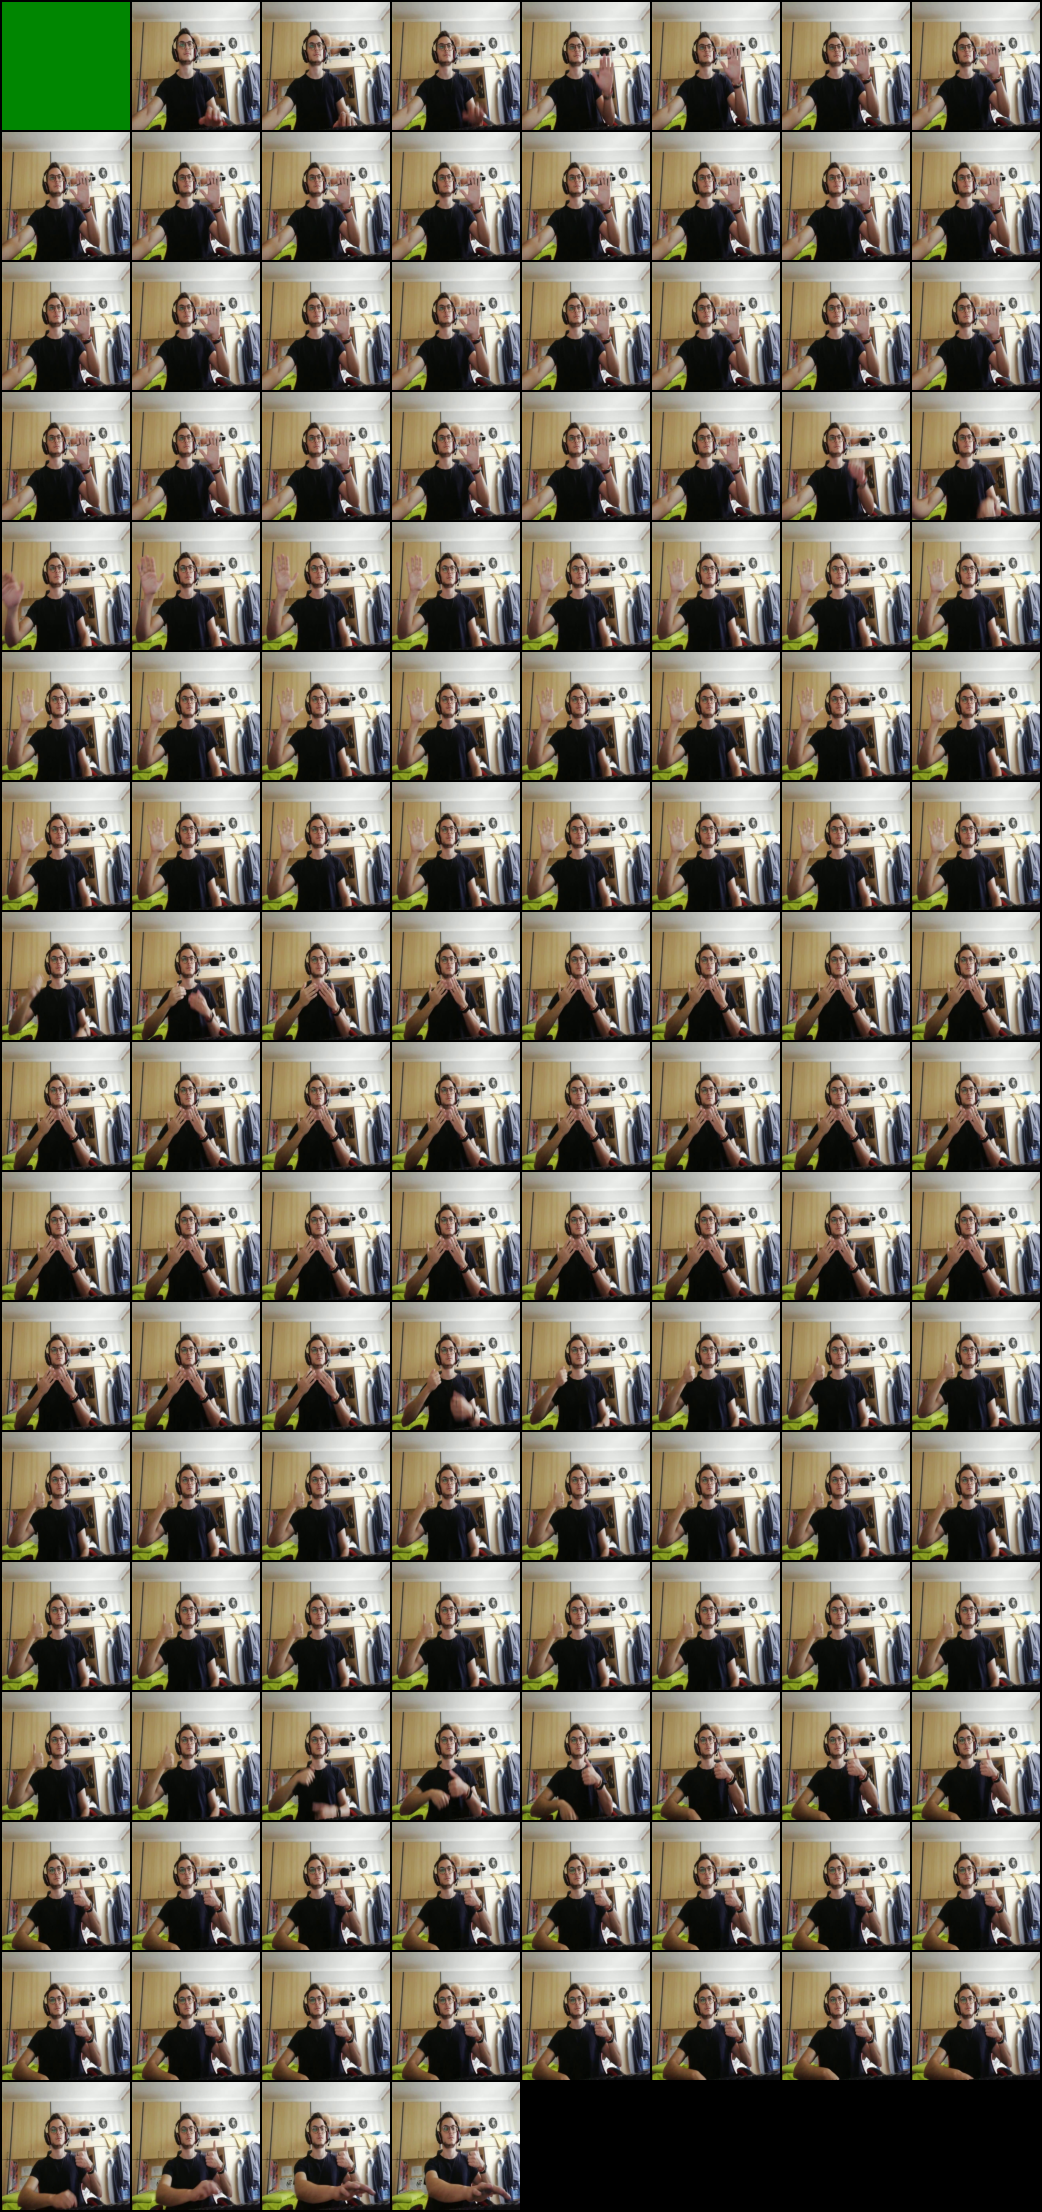

In [32]:
from IPython.display import Image
Image(filename=f'{WORKING_DIR}{video_name}-preview.png') 

## Upload extracted frames to S3 
The above script extracts every single frame from the video into the working directory. We may not want to have every frame labeled by Ground Truth workers, however, it's good to store a copy of all the frames into S3 for future use

In [34]:
!aws s3 sync $WORKING_DIR/$video_name s3://$OUTPUT_S3_BUCKET/frames/ --quiet

## Build a labeling manifest file for SageMaker Ground Truth

To train a machine learning model you need large, high-quality, labeled datasets. Labeling for thousands of images can become tedious and time consuming. Thankfully, SageMaker Ground Truth (https://aws.amazon.com/sagemaker/groundtruth/) makes it very easy to pay someone to do it for you! The Ground Truth service offers easy access to public and private human labelers and provides them with built-in workflows and interfaces for common labeling tasks, including drawing bounding boxes for object detection. 

When creating a labeling job in Ground Truth, you create a manifest file pointing to the locations of the input images stored in S3 that you want annotated. Note that each line corresponds to a single image and is an independent JSON document. 

Use the `create_manifest.py`  script to generate this manifest by specifying the s3 location of the frames you have extracted in the previous step: 

In [53]:
S3_BUCKET = OUTPUT_S3_BUCKET
S3_KEY_PREFIX = 'frames/'
SAMPLING_RATE = 10 #

In [54]:
%%time
%run ./create_manifest.py -b $S3_BUCKET -k $S3_KEY_PREFIX -d $WORKING_DIR -r $SAMPLING_RATE

INFO:__main__:storing files at: tmp/
INFO:__main__:arguments:
INFO:__main__:{'frames_s3_prefix': 'frames/', 'frames_s3_bucket': 'buckettesi', 'sampling_rate': '10', 'working_directory': 'tmp/'}
INFO:__main__:writing to manifest: tmp/frames_sampling_every_10_ground_truth_manifest.json
INFO:__main__:65 will be sent to ground truth out of 659
INFO:__main__:Generated ground truth manifest: tmp/frames_sampling_every_10_ground_truth_manifest.json


CPU times: user 140 ms, sys: 1.14 ms, total: 141 ms
Wall time: 1.11 s


In [55]:
!ls -al $WORKING_DIR/

total 4168
drwxrwxr-x 4 ec2-user ec2-user    4096 Sep 29 08:53 .
drwxrwxr-x 5 ec2-user ec2-user    4096 Sep 29 08:52 ..
drwxrwxr-x 2 ec2-user ec2-user   24576 Sep 29 08:38 demo
-rw-rw-r-- 1 ec2-user ec2-user 3007240 Sep 29 08:38 demo-preview.png
-rw-rw-r-- 1 ec2-user ec2-user    3705 Sep 29 08:53 frames_sampling_every_10_ground_truth_manifest.json
-rw-rw-r-- 1 ec2-user ec2-user    7467 Sep 29 08:39 frames_sampling_every_5_ground_truth_manifest.json
-rw-rw-r-- 1 ec2-user ec2-user    5358 Sep 29 08:51 frames_sampling_every_7_ground_truth_manifest.json
drwxrwxr-x 2 ec2-user ec2-user   12288 Sep 28 09:27 prova2
-rw-rw-r-- 1 ec2-user ec2-user 1188027 Sep 28 09:27 prova2-preview.png


In [56]:
!head $WORKING_DIR/frames_sampling_every_10_ground_truth_manifest.json

{"source-ref": "s3://buckettesi/frames/demo_000004.jpg"}
{"source-ref": "s3://buckettesi/frames/demo_000009.jpg"}
{"source-ref": "s3://buckettesi/frames/demo_000014.jpg"}
{"source-ref": "s3://buckettesi/frames/demo_000019.jpg"}
{"source-ref": "s3://buckettesi/frames/demo_000024.jpg"}
{"source-ref": "s3://buckettesi/frames/demo_000029.jpg"}
{"source-ref": "s3://buckettesi/frames/demo_000034.jpg"}
{"source-ref": "s3://buckettesi/frames/demo_000039.jpg"}
{"source-ref": "s3://buckettesi/frames/demo_000044.jpg"}
{"source-ref": "s3://buckettesi/frames/demo_000049.jpg"}


## Upload the labeling manifest to s3

In [57]:
!aws s3 cp $WORKING_DIR/frames_sampling_every_10_ground_truth_manifest.json s3://$OUTPUT_S3_BUCKET/ground_truth/

upload: tmp/frames_sampling_every_5_ground_truth_manifest.json to s3://buckettesi/ground_truth/frames_sampling_every_5_ground_truth_manifest.json


### Manifest generation tip #3: review the content of the manifest before submitting to Ground Truth

Use the `03_visualize_gt_labeling_manifest.py` script to generate a visualization of **all images included in the manifest** 

In [59]:
S3_BUCKET=OUTPUT_S3_BUCKET
S3_KEY_MANFIST='ground_truth/frames_sampling_every_10_ground_truth_manifest.json'
IMAGE_DIRECTORY= WORKING_DIR + video_name # this is an optional parameter. since we have the extracted frames still on local disk, including this will skip downloading frames from s3

In [60]:
%run ./visualize_manifest.py -b $S3_BUCKET -k $S3_KEY_MANFIST -i $IMAGE_DIRECTORY


INFO:__main__:manifest: s3://buckettesi/ground_truth/frames_sampling_every_5_ground_truth_manifest.json
INFO:__main__:sampled 131 frames
INFO:__main__:saving preview to ./frames_sampling_every_5_ground_truth_manifest_preview.png 
INFO:__main__:uploaded preview image to previews/gt-labeling-manifest/./frames_sampling_every_5_ground_truth_manifest_preview.png
INFO:__main__:processed ground_truth/frames_sampling_every_5_ground_truth_manifest.json for     7.1165 seconds.


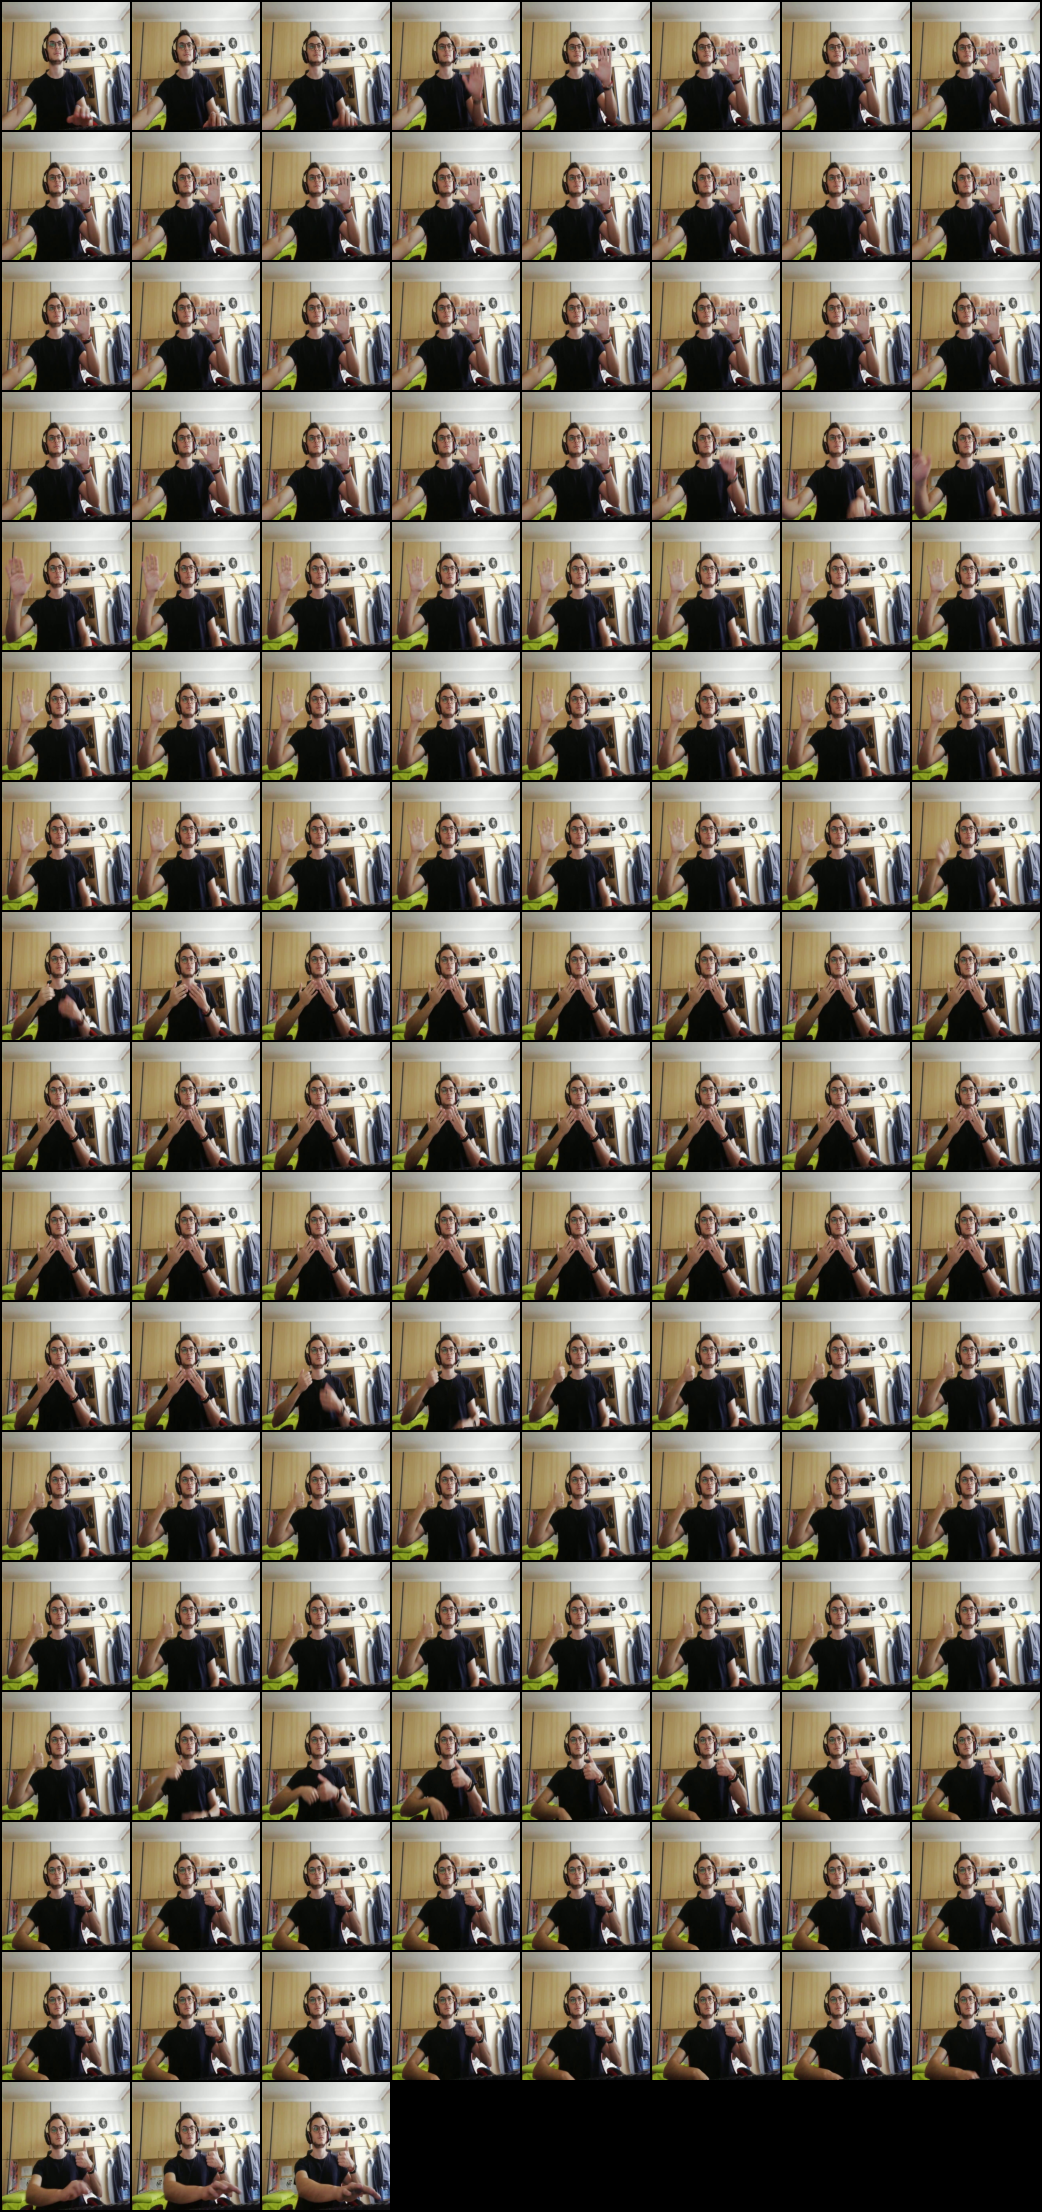

In [61]:
from IPython.display import Image
Image(filename='frames_sampling_every_10_ground_truth_manifest_preview.png') 